In [1]:
import pandas as pd
import numpy as np
from numpy import percentile
import datetime as dt
import matplotlib.pyplot as plt
plt.style.use({'figure.facecolor':'white'})
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.api import ExponentialSmoothing

### Data Import

In [2]:
df = pd.read_csv('../../data/dataset.csv', parse_dates=['datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131184 entries, 0 to 131183
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   ou        131184 non-null  float64       
 1   datetime  131184 non-null  datetime64[ns]
 2   cheques   131184 non-null  int64         
 3   rto       131184 non-null  float64       
 4   n_sku     131184 non-null  int64         
 5   cnt       131184 non-null  int64         
 6   cashnum   131184 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 7.0 MB


In [3]:
df.head()

,ou,datetime,cheques,rto,n_sku,cnt,cashnum
0,468.0,2019-11-16 08:00:00,34,8003.0,137,173,3
1,468.0,2019-11-16 09:00:00,40,20129.0,283,517,2
2,468.0,2019-11-16 10:00:00,41,15782.0,185,227,2
3,468.0,2019-11-16 11:00:00,63,39451.0,386,659,4
4,468.0,2019-11-16 12:00:00,84,57330.0,635,992,4


### Visualization timeseries

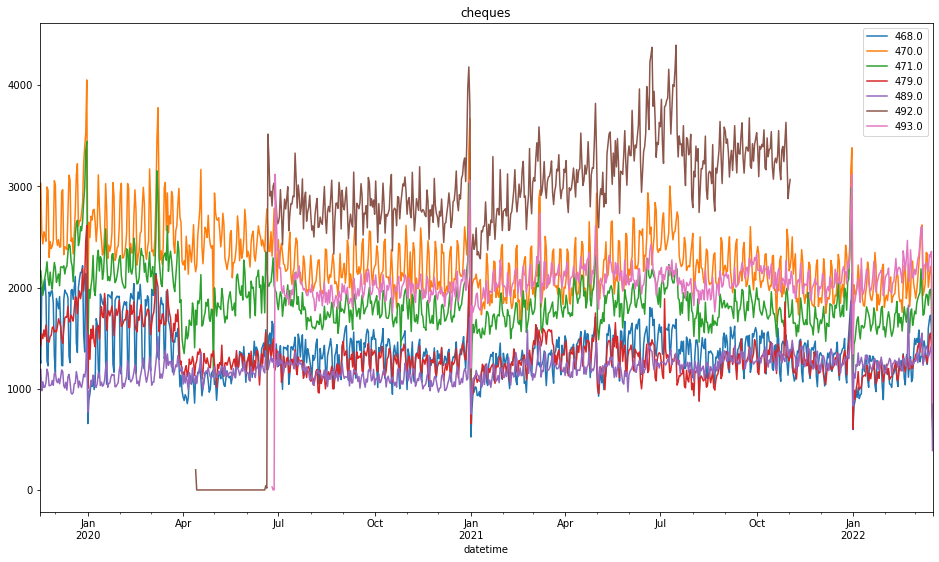

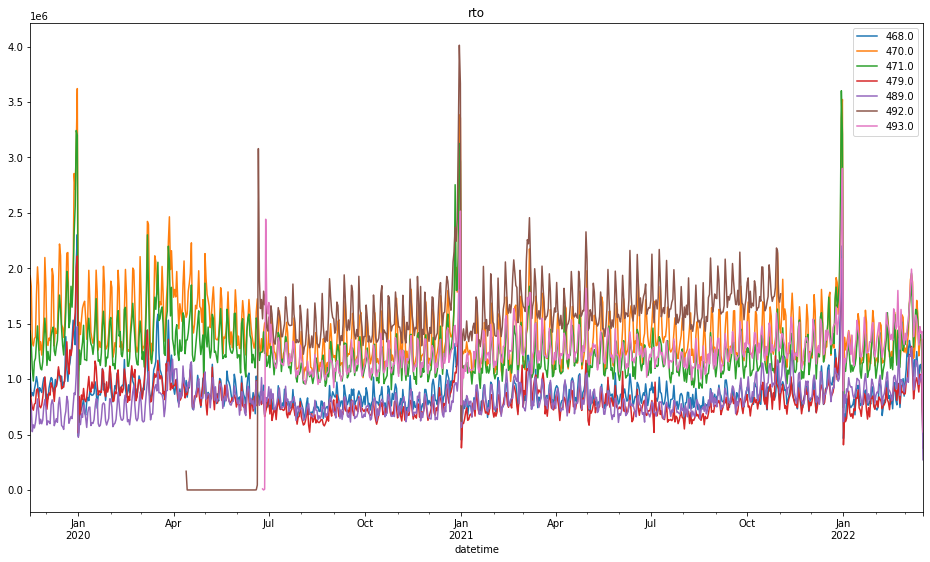

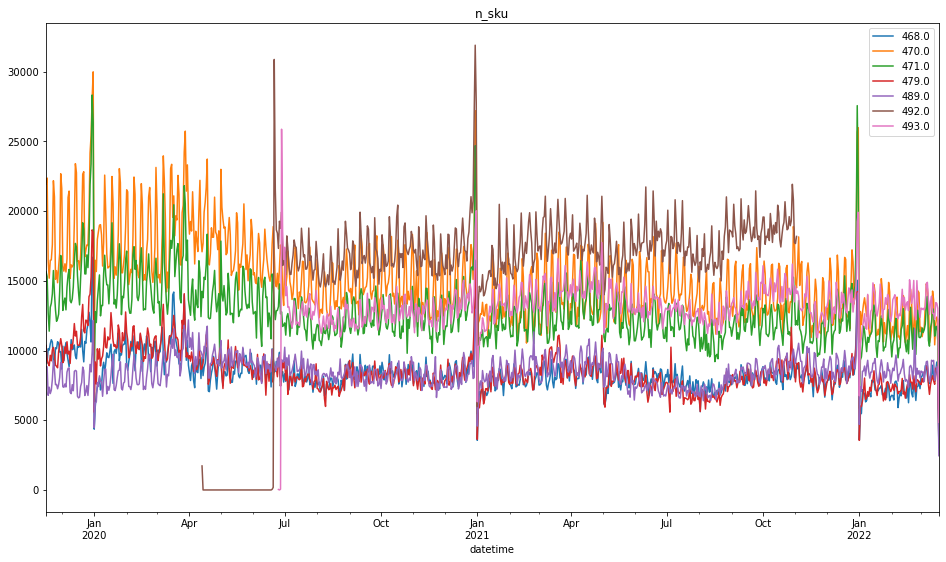

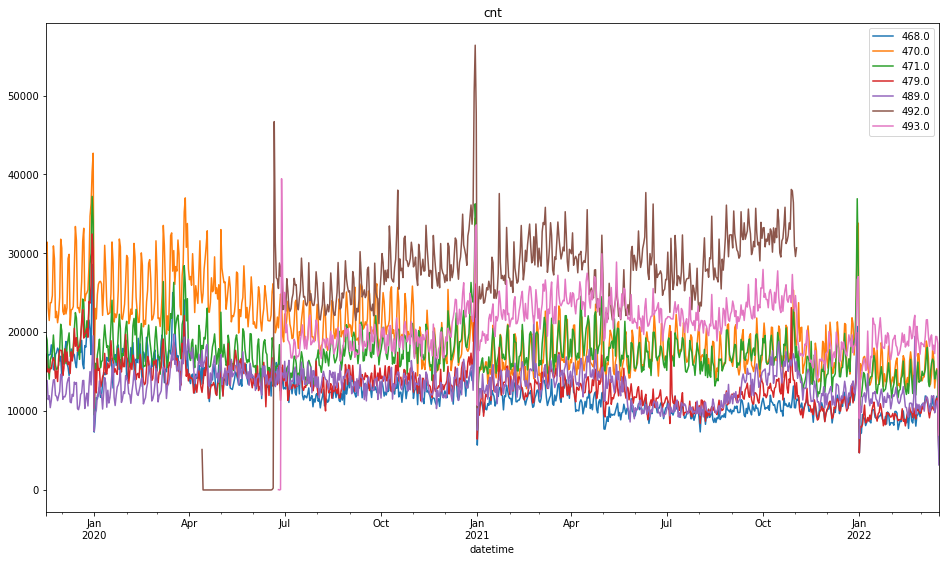

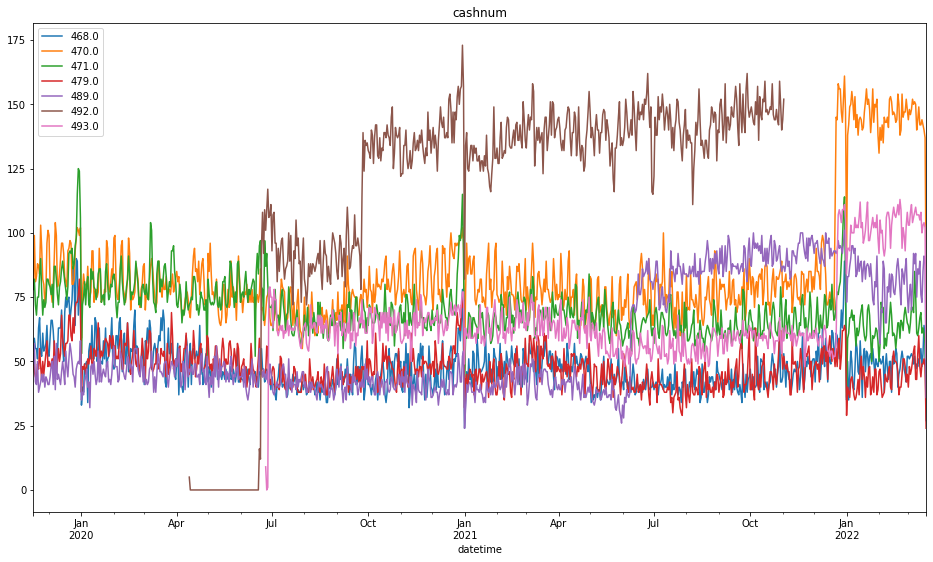

In [4]:
for clmn in ['cheques', 'rto', 'n_sku', 'cnt', 'cashnum']:
    for ou in df['ou'].unique():
        _df = df[df['ou']==ou]
        _df = _df.set_index('datetime').resample('D').sum()
        _df[clmn].plot(figsize=(16,9), label = f'{ou}')
    plt.title(f'{clmn}')
    plt.legend()
    plt.show()

In [5]:
outliers_fraction = 0.05
ou = 471
c = 'cheques'

dd = df[df['ou']==ou]
dd = dd.set_index('datetime')
dd = dd[[c]].resample('D').sum()
dd = dd[:-5]
dd.head()

,cheques
datetime,
2019-11-16,2106
2019-11-17,2169
2019-11-18,2050
2019-11-19,1924
2019-11-20,2052


### Forecast

In [6]:
df_test = dd[-50:]
df_train = dd[:-50]

In [7]:
data = df_train[c]
data.index = pd.DatetimeIndex(data.index.values, freq='D')
data

2019-11-16    2106
2019-11-17    2169
2019-11-18    2050
2019-11-19    1924
2019-11-20    2052
              ... 
2022-01-18    1570
2022-01-19    1621
2022-01-20    1642
2022-01-21    1799
2022-01-22    1743
Freq: D, Name: cheques, Length: 799, dtype: int64

In [8]:
fit = ExponentialSmoothing(data, seasonal_periods=7, trend='add', seasonal='add').fit()

In [9]:
forecast = fit.forecast(50).to_frame().reset_index()
forecast.head()

,index,0
0,2022-01-23,1694.368106
1,2022-01-24,1639.773273
2,2022-01-25,1650.659920
3,2022-01-26,1674.859061
4,2022-01-27,1715.150749


In [10]:
forecast.rename(columns={'index':'datetime', 0:'forecast'}, inplace=True)
forecast.set_index('datetime', inplace=True)
forecast.head()

,forecast
datetime,
2022-01-23,1694.368106
2022-01-24,1639.773273
2022-01-25,1650.659920
2022-01-26,1674.859061
2022-01-27,1715.150749


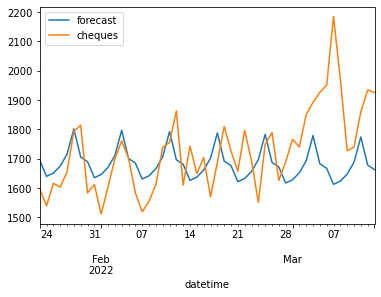

In [12]:
fig, ax =plt.subplots()
forecast.plot(ax=ax)
df_test.plot(ax=ax)
plt.show()

In [13]:
df_res = forecast.copy()
df_res['fact'] = df_test[c]
df_res['MAPE'] = abs(df_res.fact - df_res.forecast) / df_res.fact
df_res.head()

,forecast,fact,MAPE
datetime,,,
2022-01-23,1694.368106,1597,0.060969
2022-01-24,1639.773273,1539,0.065480
2022-01-25,1650.659920,1616,0.021448
2022-01-26,1674.859061,1603,0.044828
2022-01-27,1715.150749,1655,0.036345


In [14]:
threshold = percentile(df_res.MAPE, 90)
df_res['anomaly'] = df_res.MAPE > threshold
df_res.head()

,forecast,fact,MAPE,anomaly
datetime,,,,
2022-01-23,1694.368106,1597,0.060969,False
2022-01-24,1639.773273,1539,0.065480,False
2022-01-25,1650.659920,1616,0.021448,False
2022-01-26,1674.859061,1603,0.044828,False
2022-01-27,1715.150749,1655,0.036345,False


### Visualization

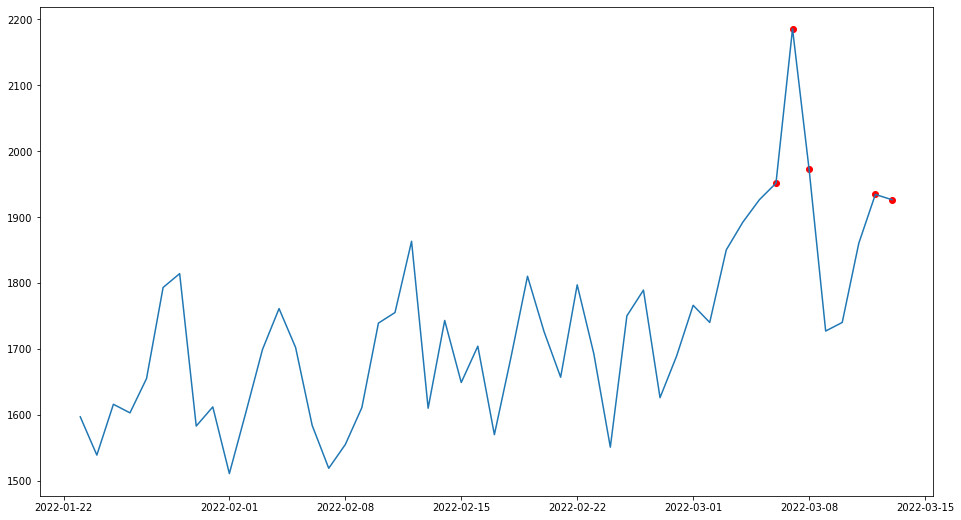

In [15]:
fig, ax = plt.subplots(figsize=(16, 9))
a = df_res.loc[df_res.anomaly, ['fact']]

ax.plot(df_res.index, df_res.fact)
ax.scatter(a.index, a.fact, color='red')
plt.show()

### Isolation Forest

In [16]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(dd.values.reshape(-1,1))
data = pd.DataFrame(np_scaled)

data.head()

,0
0,0.901392
1,1.142958
2,0.686667
3,0.203534
4,0.694335


In [17]:
model = IsolationForest(contamination=0.05)
model.fit(data)

IsolationForest(contamination=0.05)

In [18]:
dd['anomaly'] = model.predict(data)
dd.head()

,cheques,anomaly
datetime,,
2019-11-16,2106,1
2019-11-17,2169,1
2019-11-18,2050,1
2019-11-19,1924,1
2019-11-20,2052,1


### Visualization

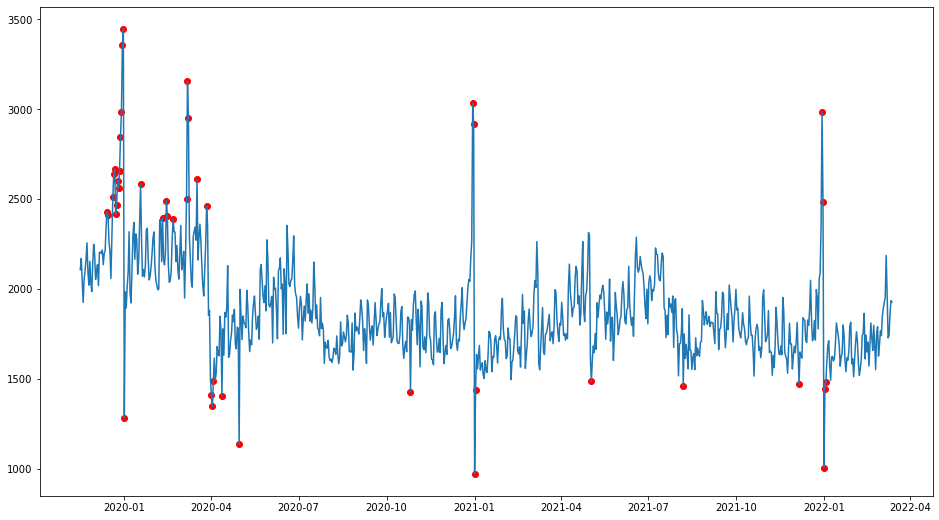

In [20]:
fig, ax = plt.subplots(figsize=(16, 9))
a = dd.loc[dd.anomaly == -1, [c]]

ax.plot(dd.index, dd[c])
ax.scatter(a.index, a[c], color='red')
plt.show()